In [3]:
import pandas as pd
import numpy as np
np.random.seed(423)
# load Excel document
file_path = r"G:\My Drive\Umich\semester 3\Fin 612\currency report\Data612.xlsx" #change it into data/Data612.xlsx, if you want to run it from my github
data= pd.read_excel(file_path, sheet_name='MC_data')
print(data.head()) #check the data

        CPI       PPI        UR        FR       INT        IP        CA
0 -0.006100  0.013657  0.093376  0.030480 -0.006308  0.112046  0.376905
1  0.004688 -0.007134  0.000050 -0.007618 -0.006348  0.024227  0.470402
2  0.018986  0.014022  0.036847  0.065416 -0.006389  0.088081 -0.200780
3  0.012159  0.010663 -0.035695  0.060819 -0.006430 -0.127502 -0.934464
4 -0.011725  0.010092  0.065569  0.021787 -0.006472  0.138044  0.720535


In [4]:
# Get column from data I have
CPI_data = data['CPI']  
UR_data = data['UR']
FR_data = data['FR']
INT_data = data['INT']
CA_data = data['CA']

# Create a DataFrame from the column I just create
historical_data = pd.DataFrame({
    'CPI_ratio_CHN': CPI_data,
    'UR_ratio_CHN': UR_data,
    'FR_ratio_CHN': FR_data,
    'INT_ratio_CHN': INT_data,
    'CA_ratio_CHN': CA_data
})

# check data
print(historical_data.head())

   CPI_ratio_CHN  UR_ratio_CHN  FR_ratio_CHN  INT_ratio_CHN  CA_ratio_CHN
0      -0.006100      0.093376      0.030480      -0.006308      0.376905
1       0.004688      0.000050     -0.007618      -0.006348      0.470402
2       0.018986      0.036847      0.065416      -0.006389     -0.200780
3       0.012159     -0.035695      0.060819      -0.006430     -0.934464
4      -0.011725      0.065569      0.021787      -0.006472      0.720535


potential better way to do this: 
# Select and rename columns directly
historical_data = data[['CPI', 'UR', 'FR', 'INT', 'CA']].rename(columns={
    'CPI': 'CPI_ratio_CHN',
    'UR': 'UR_ratio_CHN',
    'FR': 'FR_ratio_CHN',
    'INT': 'INT_ratio_CHN',
    'CA': 'CA_ratio_CHN'
})

Monte Carlo Simulation for 1 year

In [5]:
#1 calculate mean, standard deviation, and correlation matrix
means = historical_data.mean()
std_devs = historical_data.std()
#consider about the volatility of the US&China market and the political effect
volatility_factor = 2  # adjust this factor for volatility
adjusted_std_devs = std_devs * volatility_factor

correlation_matrix = historical_data.corr()
# identify whether the correlation matrix is positive_difinite
def is_positive_definite(matrix):
    eigenvalues = np.linalg.eigvals(matrix) # 计算矩阵的特征值
    return np.all(eigenvalues > 0) # 检查所有特征值是否大于零
# check whether the matrix is positive difinite and then set the epsilon 检查矩阵是否正定并设置 epsilon
if is_positive_definite(correlation_matrix):
    epsilon = 0
else:
    epsilon = float(input("The matrix is not positive definite. Please enter a value for epsilon: "))

# 打印结果
print("whether it is positive_definite:", is_positive_definite(correlation_matrix))
print("Value of epsilon:", epsilon)

# Adjust correlation matrix with epsilon
correlation_matrix_adjusted= correlation_matrix + np.eye(correlation_matrix.shape[0])*epsilon

whether it is positive_definite: True
Value of epsilon: 0


In [ ]:
# Cholesky decomposition to generate paths for correlated variables
cholesky_matrix = np.linalg.cholesky(correlation_matrix_adjusted) #将调整后的矩阵，分解成一个下三角矩阵*其转置，来保留自变量之间存在的相关关系，在后续随机数生成过程中，可以将这种相关关系赋予随机数

#3 define Manto Carlo function
def monte_carlo_simulation(timesteps, num_simulations, means, adjusted_std_devs, cholesky_matrix,dt):
    num_vars = len(means) 
    # generate normal random numbers
    random_normals = np.random.normal(size=(timesteps, num_vars, num_simulations))
    
    # Assign the correlation results obtained from the Cholesky decomposition to the generated random numbers. 将刚才cholesky分解得到的相关结果赋予生成的随机数
    correlated_randoms = np.einsum('ij,tjk->tik', cholesky_matrix, random_normals)
    '''np.einsum(subscripts, *operands) subscripts描述输入张量的维度如何相互作用，以及输出的维度如何排列。*operands 输入的矩阵或多维数组。
       'ij'：表示 cholesky_matrix 的两个维度（行和列）
       'tjk'：表示 random_normals 的三个维度（时间步 t、变量 j 和模拟次数 k）
       'tik'：表示输出矩阵的三个维度（时间步 t、变量 i 和模拟次数 k）
       运算规则是对于维度j求和，cholesky_matrix 的列（j）与 random_normals 的第二维（j）相乘并求和
    '''
    # Initialize an array to store the simulation results. 初始化用于存储模拟结果的数组
    simulations = np.zeros((timesteps, num_vars, num_simulations))
    
    # simulate each variables 对每个变量进行模拟
    for var_idx in range(num_vars): # var_idx当前正在处理的自变量的索引 （从0到num_vars-1），num_vars自变量数量，在我们的示例里应该是5个，这个循环是对每个自变量进行独立的模拟
        for sim in range(num_simulations): #num_simulations次的随机模拟，每一次随机模拟都会有一条模拟路径
            simulations[0, var_idx, sim] = historical_data.iloc[-1, var_idx]  # 从最后一个已知值开始，也就是我们模拟的初始值
            for t in range(1, timesteps): #循环从第一个时间步开始，生成从初始值到未来的多个时间部预测
                simulations[t, var_idx, sim] = (
                    simulations[t-1, var_idx, sim] +
                    means[var_idx] * dt +  # 变量确定的平均变化,dt=1的时候是一个离散模型
                    adjusted_std_devs[var_idx] * np.sqrt(dt) * correlated_randoms[t, var_idx, sim] #变量的波动部分，基于标准差和随机数生成的随机波动部分
                )
    
    return simulations

#4(1) Run the Monte Carlo simulation to predict the next year (4 quarters)
num_simulations = 20000  # 模拟次数
timesteps_1_year = 7    # 2024Q1为起点，七步之后到2025Q4，我们取最后四步的每步均值，作为当时季度的预测值，再通过这四步的预测值，求年均值
dt=1
simulations_1_year_adjusted = monte_carlo_simulation(timesteps_1_year, num_simulations, means, adjusted_std_devs, cholesky_matrix,dt)

#5 Convert the results of the first simulation path into a DataFrame to verify whether the output dimensions are correct. 将第一个模拟路径结果转为DataFrame展示确定输出结果维数是否正确
simulated_1_year_adjusted_df = pd.DataFrame(simulations_1_year_adjusted[:, :, 0], columns=historical_data.columns) #所有5个变量的第一条模拟路径
print(simulated_1_year_adjusted_df)  # 确定一下矩阵行列数是否正确

C:\Users\z1052\AppData\Local\Temp\ipykernel_6524\3356263738.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means[var_idx] * dt +  # 变量确定的平均变化,dt=1的时候是一个离散模型
C:\Users\z1052\AppData\Local\Temp\ipykernel_6524\3356263738.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adjusted_std_devs[var_idx] * np.sqrt(dt) * correlated_randoms[t, var_idx, sim] #变量的波动部分，基于标准差和随机数生成的随机波动部分


   CPI_ratio_CHN  UR_ratio_CHN  FR_ratio_CHN  INT_ratio_CHN  CA_ratio_CHN
0      -0.005207     -0.034719      0.038557       0.000000     -0.148747
1       0.009534      0.152783      0.041737      -0.788728     -0.239424
2       0.009333      0.208515      0.009086      -0.991682     -7.939737
3       0.045672     -0.211897     -0.067647      -0.568615      6.189737
4       0.039737     -0.214249     -0.068920      -1.215386     26.378540
5       0.065572      0.224914     -0.018935       1.037741     -1.214075
6       0.092725      0.007560     -0.103402       2.279728    -11.180511


In [10]:
#6：Calculate the mean of each time step and variable across all 20,000 simulation paths. 计算每个时间步和变量在所有2万条模拟路径上的均值
# Take the mean along the simulation path axis (axis=2)
mean_simulations1 = np.mean(simulations_1_year_adjusted, axis=2) #axis=2取第 2 维上所有模拟路径的均值

# Change the results into DataFrame
mean_simulations1_df = pd.DataFrame(mean_simulations1, columns=historical_data.columns)

# check the outcome
print(mean_simulations1_df)

   CPI_ratio_CHN  UR_ratio_CHN  FR_ratio_CHN  INT_ratio_CHN  CA_ratio_CHN
0      -0.005207     -0.034719      0.038557       0.000000     -0.148747
1      -0.006379     -0.021087      0.049587      -0.075786     -0.131511
2      -0.007323     -0.003090      0.059473      -0.155002     -0.198438
3      -0.008437      0.011295      0.070168      -0.231795     -0.129834
4      -0.009347      0.031313      0.080510      -0.311740     -0.171549
5      -0.010561      0.053767      0.091133      -0.396285     -0.036755
6      -0.011591      0.071091      0.102522      -0.462964     -0.192339


In [14]:
##7 Substitute the calculated X prediction values into the linear regression equation to solve for Y ratio
# Use the beta we have got from others result
beta0 = -0.0020  # 截距项
beta1 = -0.5928  # CPI 系数
beta2 = -0.0323  # UR 系数
beta3 = 0.1698  # FR 系数
beta4 = -0.0148  # INT 系数
beta5 = -0.0013  # CA 系数

# Introduce a coefficient scaling factor
scale_factor = 0.01

# Set X matrix
X_mean1=mean_simulations1_df

#  Calculate ln(Y_ratio)
ln_Y_ratio = (
    scale_factor*beta0 +
    scale_factor*beta1 * X_mean1['CPI_ratio_CHN'] +
    scale_factor*beta2 * X_mean1['UR_ratio_CHN'] +
    scale_factor*beta3 * X_mean1['FR_ratio_CHN'] +
    scale_factor*beta4 * X_mean1['INT_ratio_CHN'] +
    scale_factor*beta5 * X_mean1['CA_ratio_CHN']
)

# convert ln(Y) into Y
Y1_ratio_pred = np.exp(ln_Y_ratio)

# print final Y prediction
print("predicted future one year Y ratio (7 timesteps) :", Y1_ratio_pred)


predicted future one year Y ratio (7 timesteps) : 0    1.000089
1    1.000122
2    1.000151
3    1.000182
4    1.000210
5    1.000239
6    1.000271
dtype: float64


In [15]:
##8 Subsititute future 7 timesteps Y prediction to calculate exact Y(因为一开始的数据是计算完的ln(Yt/Yt-1))
initial_rate = 7.2018  # 这是 CNYUSD 的初始汇率值

# Use the predicted Y ratio to calculate future Y
predicted_exchange_rates1 = [initial_rate]  # 初始化列表，起点为初始汇率
for i in range(len(Y1_ratio_pred)):
    next_rate = predicted_exchange_rates1[-1] * Y1_ratio_pred.iloc[i]  # 将上一个汇率乘以 Y_pred 的比值
    predicted_exchange_rates1.append(next_rate)

# Show the result
predicted_exchange_rates1 = np.array(predicted_exchange_rates1[1:])  # 从第二个开始，去掉初始值
print("predicted future one year (7 timesteps) :", predicted_exchange_rates1)

predicted future one year (7 timesteps) : [7.20244448 7.20332145 7.20440863 7.20571639 7.20723238 7.2089559
 7.21090871]


In [16]:
##9 Extract the last four exchange rate values
last_four_rates1 = predicted_exchange_rates1[-4:]

# Calculate the mean of last 4 values
average_rate_1 = np.mean(last_four_rates1)

# Step 3: 打印最后四个汇率值和它们的均值
print("last four exchange rate values:", last_four_rates1)
print("Average exchange rate for year 2025 :", average_rate_1)

last four exchange rate values: [7.20571639 7.20723238 7.2089559  7.21090871]
Average exchange rate for year 2025 : 7.208203344483442


Monte Carlo Simulation for 3 years

In [18]:
#4(2) Run the Monte Carlo simulation to predict the next 3 years (12 quarters)
num_simulations = 20000  # 模拟次数
timesteps_3_years = 15    # 3年=12个季度，加上2024年剩余的3个季度
dt=1
simulations_3_years_adjusted = monte_carlo_simulation(timesteps_3_years, num_simulations, means, std_devs, cholesky_matrix,dt)

# Check the value
simulated_3_years_adjusted_df = pd.DataFrame(simulations_3_years_adjusted[1:5, :, 0], columns=historical_data.columns)
simulated_3_years_adjusted_df.head()  # 展示第一个模拟路径的前几行

C:\Users\z1052\AppData\Local\Temp\ipykernel_6524\3356263738.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means[var_idx] * dt +  # 变量确定的平均变化,dt=1的时候是一个离散模型
C:\Users\z1052\AppData\Local\Temp\ipykernel_6524\3356263738.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adjusted_std_devs[var_idx] * np.sqrt(dt) * correlated_randoms[t, var_idx, sim] #变量的波动部分，基于标准差和随机数生成的随机波动部分


,CPI_ratio_CHN,UR_ratio_CHN,FR_ratio_CHN,INT_ratio_CHN,CA_ratio_CHN
0,0.008197,0.150044,0.010495,0.306587,-6.123065
1,0.006648,-0.036560,-0.014911,0.533328,-3.517863
2,-0.012032,-0.164878,0.046005,-0.060398,5.460408
3,-0.016376,-0.297041,0.123190,-0.650046,17.683651


In [19]:
#6：Calculate the mean of each time step and variable across all 20,000 simulation paths. 计算每个时间步和变量在所有2万条模拟路径上的均值
# 沿着模拟路径的轴（axis=2）取均值
mean_simulations3 = np.mean(simulations_3_years_adjusted, axis=2)

# Change the results into DataFrame
mean_simulations3_df = pd.DataFrame(mean_simulations3, columns=historical_data.columns)

# Check the outcomes
print(mean_simulations3_df)

    CPI_ratio_CHN  UR_ratio_CHN  FR_ratio_CHN  INT_ratio_CHN  CA_ratio_CHN
0       -0.005207     -0.034719      0.038557       0.000000     -0.148747
1       -0.006439     -0.017598      0.048923      -0.074207     -0.074535
2       -0.007609     -0.000994      0.059537      -0.146514     -0.099807
3       -0.008784      0.017031      0.069842      -0.223619     -0.099245
4       -0.010121      0.036668      0.080557      -0.302877     -0.004246
5       -0.011193      0.054391      0.090535      -0.380562      0.076670
6       -0.012470      0.073719      0.101049      -0.452583     -0.010516
7       -0.013530      0.090088      0.111531      -0.525099      0.014680
8       -0.014643      0.108233      0.122331      -0.604239      0.058424
9       -0.015760      0.126167      0.133006      -0.682694      0.085083
10      -0.017078      0.144213      0.143154      -0.759957      0.127362
11      -0.018410      0.160909      0.153341      -0.830740      0.069221
12      -0.019738      0.

In [20]:
##7 Substitute the calculated X prediction values into the linear regression equation to solve for Y ratio
# Use the beta we have got from others result
beta0 = -0.0020  # 截距项
beta1 = -0.5928  # CPI 系数
beta2 = -0.0323  # UR 系数
beta3 = 0.1698  # FR 系数
beta4 = -0.0148  # INT 系数
beta5 = -0.0013  # CA 系数

#Introduce a coefficient scaling factor
scale_factor = 0.01

# Extract the mean of X3 prediction
X3_mean = mean_simulations3_df  # 自变量的均值DataFrame

# Calculate ln(Y3_ratio)
ln_Y3_ratio = (
    scale_factor*beta0 +
    scale_factor*beta1 * X3_mean['CPI_ratio_CHN'] +
    scale_factor*beta2 * X3_mean['UR_ratio_CHN'] +
    scale_factor* beta3 * X3_mean['FR_ratio_CHN'] +
    scale_factor* beta4 * X3_mean['INT_ratio_CHN'] +
    scale_factor* beta5 * X3_mean['CA_ratio_CHN']
)

# Convert ln(Y3_ratio) into Y_ratio
Y3_ratio_pred = np.exp(ln_Y3_ratio)

# print
print("predicted future one year Y ratio(15 timesteps):", Y3_ratio_pred)

predicted future one year Y ratio(15 timesteps): 0     1.000089
1     1.000119
2     1.000150
3     1.000180
4     1.000210
5     1.000238
6     1.000269
7     1.000298
8     1.000328
9     1.000359
10    1.000389
11    1.000420
12    1.000450
13    1.000480
14    1.000510
dtype: float64


In [21]:
##8 Subsititute future 15 timesteps Y3 prediction to calculate exact Y(因为一开始的数据是计算完的ln(Yt/Yt-1))
initial_rate = 7.2018  # 这是 CNYUSD 的初始汇率值

# Use the predicted Y ratio to calculate future Y
predicted_exchange_rates3 = [initial_rate]  # 初始化列表，起点为初始汇率
for i in range(len(Y3_ratio_pred)):
    next_rate = predicted_exchange_rates3[-1] * Y3_ratio_pred.iloc[i]  # 将上一个汇率乘以 Y3_pred 的比值
    predicted_exchange_rates3.append(next_rate)

# print
predicted_exchange_rates3 = np.array(predicted_exchange_rates3[1:])  # 从第二个开始，去掉初始值
print("predicted future three year (15 timesteps):", predicted_exchange_rates3)

predicted future three year (15 timesteps): [7.20244448 7.20330072 7.20437773 7.20567139 7.20718344 7.20889779
 7.21083588 7.21298511 7.215353   7.21793981 7.22074488 7.22377521
 7.22702474 7.23049302 7.23418152]


In [22]:
##9 Extract the last four exchange rate values
last_four_rates3 = predicted_exchange_rates3[-4:]

# Calculate the mean of last 4 values
average_rate_3 = np.mean(last_four_rates3)

print("last four exchange rate values:", last_four_rates3)
print("Average exchange rate for year 2027 :", average_rate_3)

last four exchange rate values: [7.22377521 7.22702474 7.23049302 7.23418152]
Average exchange rate for year 2027 : 7.228868625811039


Monte Carlo Simulation for 5 years

In [23]:
#4(3) Run the Monte Carlo simulation to predict the next 5 years (20 quarters)
num_simulations = 20000  # 模拟次数
timesteps_5_years = 23    # 5年=20个季度，加上2024本身的三个季度
dt=1
simulations_5_years_adjusted = monte_carlo_simulation(timesteps_5_years, num_simulations, means, std_devs, cholesky_matrix,dt)

# Check
simulated_5_years_adjusted_df = pd.DataFrame(simulations_5_years_adjusted[1:5, :, 0], columns=historical_data.columns)
simulated_5_years_adjusted_df.head()  # 展示第一个模拟路径的前几行

C:\Users\z1052\AppData\Local\Temp\ipykernel_6524\3356263738.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means[var_idx] * dt +  # 变量确定的平均变化,dt=1的时候是一个离散模型
C:\Users\z1052\AppData\Local\Temp\ipykernel_6524\3356263738.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adjusted_std_devs[var_idx] * np.sqrt(dt) * correlated_randoms[t, var_idx, sim] #变量的波动部分，基于标准差和随机数生成的随机波动部分


,CPI_ratio_CHN,UR_ratio_CHN,FR_ratio_CHN,INT_ratio_CHN,CA_ratio_CHN
0,-0.016758,-0.250822,0.029233,0.313853,-2.876570
1,-0.005130,-0.255768,0.059545,0.556575,-9.976972
2,-0.007776,-0.178914,0.053868,0.345738,-11.828293
3,0.009099,-0.345816,0.051791,0.771012,-8.878881


In [24]:
#6：Calculate the mean of each time step and variable across all 20,000 simulation paths. 计算每个时间步和变量在所有2万条模拟路径上的均值
# 沿着模拟路径的轴（axis=2）取均值
mean_simulations5 = np.mean(simulations_5_years_adjusted, axis=2)

# Turn the results into DataFrame
mean_simulations5_df = pd.DataFrame(mean_simulations5, columns=historical_data.columns)

# check
print(mean_simulations5_df)

    CPI_ratio_CHN  UR_ratio_CHN  FR_ratio_CHN  INT_ratio_CHN  CA_ratio_CHN
0       -0.005207     -0.034719      0.038557       0.000000     -0.148747
1       -0.006442     -0.013760      0.049028      -0.079793     -0.128294
2       -0.007709      0.003785      0.059509      -0.155224     -0.098340
3       -0.008853      0.021727      0.070161      -0.228867     -0.099264
4       -0.009902      0.040276      0.080632      -0.305118     -0.101077
5       -0.011223      0.057568      0.091047      -0.385522     -0.079838
6       -0.012493      0.076593      0.101394      -0.453264     -0.141095
7       -0.013749      0.092165      0.111963      -0.529745     -0.069936
8       -0.015044      0.109769      0.122435      -0.606475     -0.117250
9       -0.016249      0.125520      0.132765      -0.681045     -0.082406
10      -0.017530      0.144997      0.143058      -0.755803      0.002396
11      -0.018698      0.162579      0.153128      -0.827445      0.022870
12      -0.019980      0.

In [28]:
##7 Substitute the calculated X prediction values into the linear regression equation to solve for Y ratio
# Use the beta we have got from others result
beta0 = -0.0020  # 截距项
beta1 = -0.5928  # CPI 系数
beta2 = -0.0323  # UR 系数
beta3 = 0.1698  # FR 系数
beta4 = -0.0148  # INT 系数
beta5 = -0.0013  # CA 系数

#Introduce a coefficient scaling factor
scale_factor = 0.01

# Extract the mean of X3 prediction
X5_mean = mean_simulations5_df  # 自变量的均值DataFrame

# Claculate ln(Y_ratio)
ln_Y5_ratio = (
    scale_factor*beta0 +
    scale_factor* beta1 * X5_mean['CPI_ratio_CHN'] +
    scale_factor* beta2 * X5_mean['UR_ratio_CHN'] +
    scale_factor* beta3 * X5_mean['FR_ratio_CHN'] +
    scale_factor*beta4 * X5_mean['INT_ratio_CHN'] +
    scale_factor*beta5 * X5_mean['CA_ratio_CHN']
)

# Convert ln(Y_ratio) into Y
Y5_ratio_pred = np.exp(ln_Y5_ratio)

# Check
print("predicted future five year Y ratio(23 timesteps):", Y5_ratio_pred)


predicted future five year Y ratio(23 timesteps): 0     1.000089
1     1.000119
2     1.000150
3     1.000180
4     1.000209
5     1.000241
6     1.000270
7     1.000301
8     1.000333
9     1.000363
10    1.000392
11    1.000421
12    1.000451
13    1.000483
14    1.000514
15    1.000544
16    1.000575
17    1.000605
18    1.000636
19    1.000666
20    1.000696
21    1.000727
22    1.000757
dtype: float64


In [30]:
##8 Subsititute future 15 timesteps Y3 prediction to calculate exact Y(因为一开始的数据是计算完的ln(Yt/Yt-1))
initial_rate = 7.2018  # 这是 CNYUSD 的初始汇率值

# # Use the predicted Y ratio to calculate future Y
predicted_exchange_rates5 = [initial_rate]  # 初始化列表，起点为初始汇率
for i in range(len(Y5_ratio_pred)):
    next_rate = predicted_exchange_rates5[-1] * Y5_ratio_pred.iloc[i]  # 将上一个汇率乘以 Y_pred 的比值
    predicted_exchange_rates5.append(next_rate)

# check
predicted_exchange_rates5 = np.array(predicted_exchange_rates5[1:])  # 从第二个开始，去掉初始值
print("predicted future five year Y (23 timesteps):", predicted_exchange_rates5)

predicted future five year Y (23 timesteps): [7.20244448 7.20330421 7.20438316 7.20567833 7.207185   7.20891948
 7.21086907 7.21304102 7.21544267 7.21806293 7.2208917  7.22392876
 7.2271841  7.23067443 7.23439025 7.23832929 7.242491   7.24687495
 7.25148224 7.25630835 7.26136234 7.2666417  7.27214114]


In [31]:
##9 Extract the last four exchange rate values
last_four_rates5 = predicted_exchange_rates5[-4:]

# Calculate the mean of last four values
average_rate_5 = np.mean(last_four_rates5)

# print
print("Last four exchange rate:", last_four_rates5)
print("the predicted exchange value for year 2029 :", average_rate_5)

Last four exchange rate: [7.25630835 7.26136234 7.2666417  7.27214114]
the predicted exchange value for year 2029 : 7.264113383633167


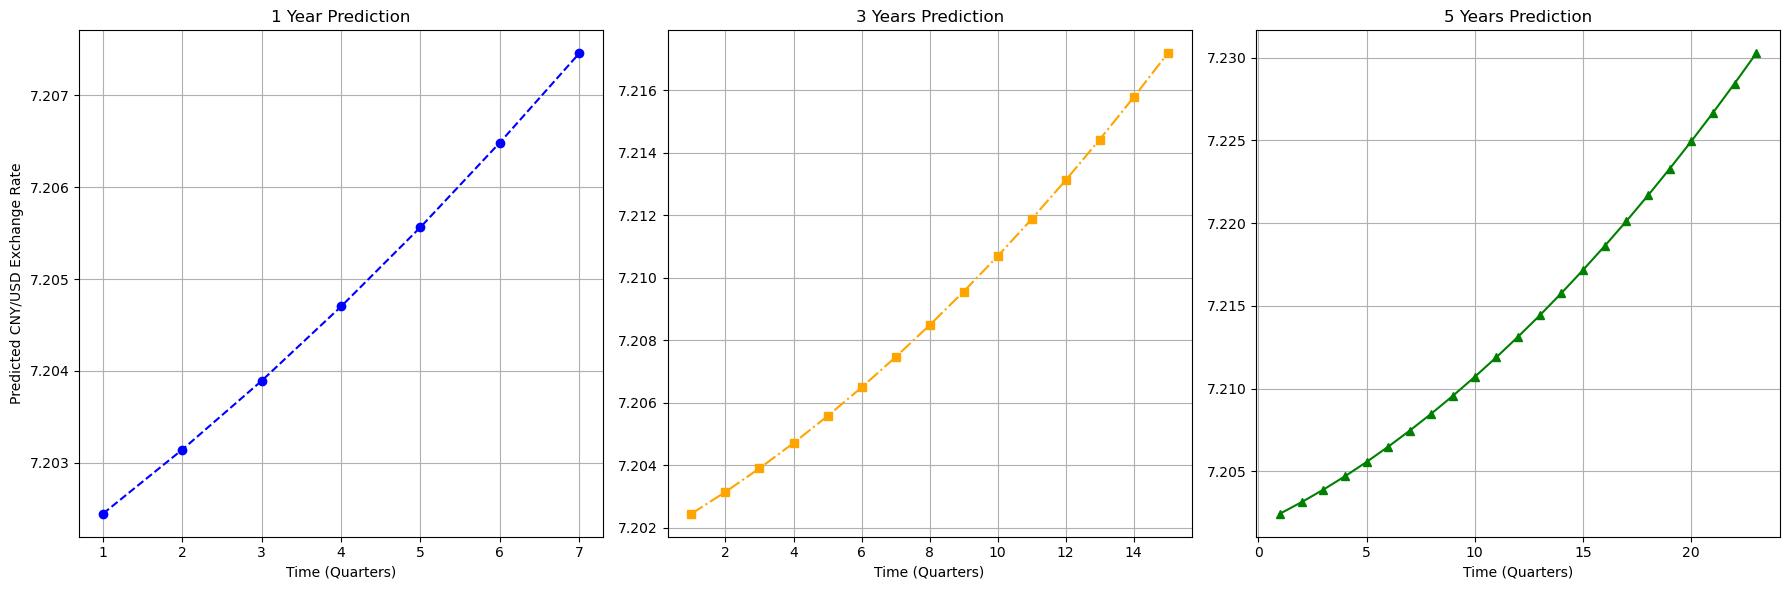

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# 时间步数
time_1_year = np.arange(1, 8)   # 1年
time_3_years = np.arange(1, 16)  # 3年
time_5_years = np.arange(1, 24)  # 5年

# 预测的平均汇率数据
predicted_exchange_rates_1_year = [7.20244448, 7.20314275, 7.20389235, 7.20470103, 7.20556473, 7.20648579, 7.20745748]
predicted_exchange_rates_3_years = [7.20244448, 7.20314237, 7.20389638, 7.20470497, 7.20556754, 7.20648433, 7.20745561, 7.20847634, 7.20955086, 7.21068308, 7.21186956, 7.21311451, 7.21441566, 7.21576864, 7.21717461]
predicted_exchange_rates_5_years = [7.20244448, 7.20314238, 7.20389327, 7.20470217, 7.20556803, 7.20649126, 7.20746681, 7.20849601, 7.20957734, 7.21071211, 7.2118986, 7.21313512, 7.21442184, 7.21576574, 7.2171638, 7.21861286, 7.22011289, 7.22166784, 7.22327639, 7.22494012, 7.226658, 7.22842851, 7.23025336]

# 创建1行3列的子图
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 绘制1年预测的折线图
axes[0].plot(time_1_year, predicted_exchange_rates_1_year, color='blue', marker='o', linestyle='--')
axes[0].set_title('1 Year Prediction')
axes[0].set_xlabel('Time (Quarters)')
axes[0].set_ylabel('Predicted CNY/USD Exchange Rate')
axes[0].grid(True)

# 绘制3年预测的折线图
axes[1].plot(time_3_years, predicted_exchange_rates_3_years, color='orange', marker='s', linestyle='-.')
axes[1].set_title('3 Years Prediction')
axes[1].set_xlabel('Time (Quarters)')
axes[1].grid(True)

# 绘制5年预测的折线图
axes[2].plot(time_5_years, predicted_exchange_rates_5_years, color='green', marker='^', linestyle='-')
axes[2].set_title('5 Years Prediction')
axes[2].set_xlabel('Time (Quarters)')
axes[2].grid(True)

# 调整子图布局
plt.tight_layout()

# 显示图表
plt.show()


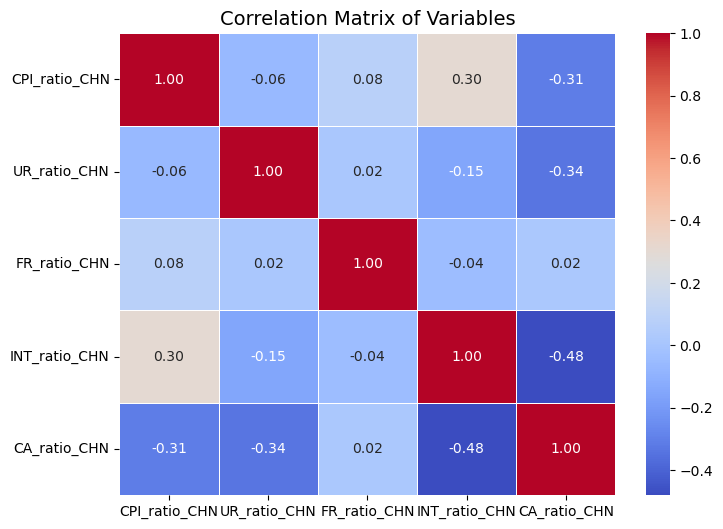

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# 使用之前计算的相关矩阵绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

# 设置标题
plt.title('Correlation Matrix of Variables', fontsize=14)

# 保存热力图为PNG文件
plt.savefig('correlation_matrix_heatmap.png', dpi=300, bbox_inches='tight')

# 显示图表
plt.show()
